In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
import io
import os
from PIL import Image
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.utils import shuffle
import cv2
import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from tensorflow.keras.models import load_model, save_model
from tensorflow.keras.applications import EfficientNetB0
import seaborn as sns
print("imported all!")

imported all!


In [3]:
X = []
Y = []
size = 150
# We find where our training MRI Scans images are saved at
train_im = 'Brain-Tumor-Classification-DataSet-master\Training'
# We get the labels from the directory at the given local path, later printing them out to verify
labels = os.listdir(train_im)
print(labels)

['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']


In [4]:
# Will append all the images and their corresponding labels to an array,
# both the testing and training values

# X Will store the image itself
X = []
# Y will contain the label corresponding to ith, image
Y = []

# Iterates through all of the labels 
for i in labels:
    # Creates a path joining the tranining as well as what folder/label we want to open
    fldr = os.path.join('Brain-Tumor-Classification-DataSet-master',"Training",i)
    # This lists all the files within the folder we open ^
    for j in tqdm(os.listdir(fldr)):
        # Loads the image using .imread when given a path and j, the file. 
        img = cv2.imread(os.path.join(fldr,j))
        # Resizes the image to a predetermine value for consistency among the images. 
        img = cv2.resize(img,(size,size))
        # We add the image to X, and its label to Y
        X.append(img)
        Y.append(i)


100%|██████████| 827/827 [00:02<00:00, 393.27it/s]


In [5]:
# Repeats the same process for testing
for i in labels:
    fldr = os.path.join("Brain-Tumor-Classification-DataSet-master","Testing",i)
    for j in tqdm(os.listdir(fldr)):
        img = cv2.imread(os.path.join(fldr,j))
        img = cv2.resize(img,(size,size))
        X.append(img)
        Y.append(i)


100%|██████████| 74/74 [00:00<00:00, 184.84it/s]


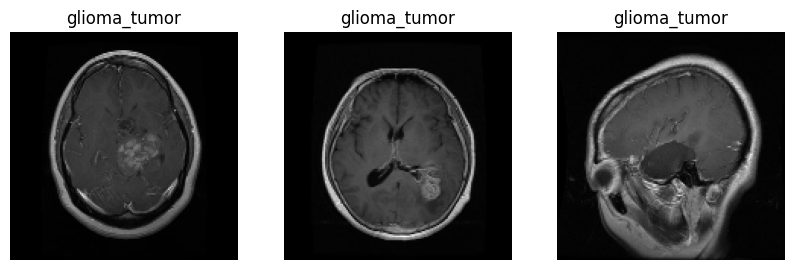

In [6]:
_,fig = plt.subplots(1,3,figsize = (10,10))
for ax,image,label in zip(fig,X,Y):
    ax.set_axis_off()
    ax.imshow(image,cmap=plt.cm.gray_r)
    ax.set_title(label)

In [7]:
# Converts our normal array into a numpy array 
X = np.array(X)
Y = np.array(Y)

In [8]:
# We randomize our data
X, Y = shuffle(X,Y,random_state=42)

X.shape

(3264, 150, 150, 3)

In [9]:
# Okay now we split our data into testing and training, with a training size of 80% and a test size of 20% 
x_train, x_test, y_train,y_test = train_test_split(X,Y,test_size=.2,random_state=33)

In [10]:
# We perform One Hot Encodding on our labels after converting them into numbers

Y_new_train = []
# Taking the labels from our training set we then correlte the label to its index from the array
# and save it into Y_new
for i in y_train:
    Y_new_train.append(labels.index(i))
y_train = Y_new_train
y_train = tf.keras.utils.to_categorical(y_train)


In [11]:
print(y_train)

[[1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 ...
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]]


In [12]:
# Now we do the same for our testing labels
Y_new_test = []
# Taking the labels from our testing set we then correlte the 
# label to its index from the array and save it into Y_new
for i in y_test:
    Y_new_test.append(labels.index(i))
y_test = Y_new_test
y_test = tf.keras.utils.to_categorical(y_test)

In [13]:
# We are gonna use transfer learning as it uses less computation power
# than deep learning and its more efficient too. We first import a pre-built model
# to build our model on top
effnet = EfficientNetB0(weights='imagenet',include_top=False,input_shape=(size,size,3))

In [14]:
tumor_model = effnet.output

tumor_model = tf.keras.layers.GlobalAveragePooling2D()(tumor_model)

tumor_model = tf.keras.layers.Dropout(rate=.5)(tumor_model)

tumor_model = tf.keras.layers.Dense(4,activation='softmax')(tumor_model)

tumor_model = tf.keras.models.Model(inputs = effnet.input,outputs = tumor_model)

In [15]:
tumor_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 150, 150,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 150, 150,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 150, 150,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 151, 151,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 75, 75,    │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 75, 75,    │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 75, 75,    │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 75, 75,    │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 75, 75,    │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 75, 75,    │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 75, 75,    │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 75, 75,    │        512 │ block1a_se_excit

 Total params: 4,054,695 (15.47 MB)

 Trainable params: 4,012,672 (15.31 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [16]:
tumor_model.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])

In [17]:
tensorboard = TensorBoard(log_dir = "logs")

checkpoint = ModelCheckpoint("effnet.weights.h5",monitor="val_accuracy",save_best_only=True,mode = "auto",verbose = 1,save_weights_only=True)

reduce_lr = ReduceLROnPlateau(monitor= "val_accuracy",factor=.3,patience=2,min_delta=.001,mode="auto",verbose=1)



In [18]:

history = tumor_model.fit(x_train,y_train,validation_split = 0.1, epochs = 10, verbose=1, batch_size = 32 ,callbacks=[tensorboard,checkpoint,reduce_lr])


Epoch 1/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7463 - loss: 0.6618
Epoch 1: val_accuracy improved from -inf to 0.83969, saving model to effnet.weights.h5
74/74 ━━━━━━━━━━━━━━━━━━━━ 137s 1s/step - accuracy: 0.7473 - loss: 0.6596 - val_accuracy: 0.8397 - val_loss: 0.6340 - learning_rate: 0.0010
Epoch 2/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9092 - loss: 0.2442
Epoch 2: val_accuracy improved from 0.83969 to 0.92748, saving model to effnet.weights.h5
74/74 ━━━━━━━━━━━━━━━━━━━━ 98s 1s/step - accuracy: 0.9095 - loss: 0.2438 - val_accuracy: 0.9275 - val_loss: 0.2614 - learning_rate: 0.0010
Epoch 3/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9525 - loss: 0.1484
Epoch 3: val_accuracy improved from 0.92748 to 0.95802, saving model to effnet.weights.h5
74/74 ━━━━━━━━━━━━━━━━━━━━ 99s 1s/step - accuracy: 0.9525 - loss: 0.1484 - val_accuracy: 0.9580 - val_loss: 0.1738 - learning_rate: 0.0010
Epoch 4/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.962

In [19]:
classified_labels = tumor_model.predict(x_test)
classified_labels = np.argmax(classified_labels,axis=1)

y_test_new = np.argmax(y_test,axis=1)

21/21 ━━━━━━━━━━━━━━━━━━━━ 9s 318ms/step


In [20]:
print(metrics.classification_report(y_test_new,classified_labels))

              precision    recall  f1-score   support

           0       0.99      0.93      0.96       201
           1       0.90      0.99      0.94       174
           2       0.97      0.97      0.97        96
           3       0.99      0.97      0.98       182

    accuracy                           0.96       653
   macro avg       0.96      0.96      0.96       653
weighted avg       0.96      0.96      0.96       653



In [21]:
print(metrics.confusion_matrix(classified_labels,y_test_new))

[[186   0   1   0]
 [ 13 172   2   5]
 [  2   1  93   0]
 [  0   1   0 177]]


In [22]:
tumor_model.save_weights("model.weights.h5")

In [23]:
tumor_model.save("tumor_model.keras")

In [24]:
model = load_model("D:\MasterProgramming\WIP_2025\CODE\PROJECTS\BrainTumorLearning\\tumor_model.keras")